* For a NMF_kl fit on dataset "montoro_droplet", I computed p-value for each component using poisson distribution. There are two ways. One is directly using ```ppois(x, lam)```, the other is ```c*ppois(x-1, lam) + (1-c)*ppos(x,lam), where c ~ U(0,1)```. I call the first one "Poisson p value", the second one "Poisson continuous pvalue" 

* I try to find out those with very big p values

* I compute eigenvalues for the binary matrix with one for each entry with very big p-value (0.99)


to avoid confusion: 
* the `rank1` refers to Yongsok's rank-one update algorithm. 
* Poisson_cts means "Poisson continuous pvalue" 

## Result:
* the histogram of p-values are shown below (note the data is sparse, with 90% 0s)(cannot display in html so I put the link) https://github.com/zihao12/lowrank-nmf/blob/master/output/montoro_droplet_rank1_K13_pval_poisson.png and https://github.com/zihao12/lowrank-nmf/blob/master/output/montoro_droplet_rank1_K13_pval_poisson_cts.png

* I cannot find a small subset of genes that are responsible for those fits with big p values (>0.99)

* There is a big eigenvalue of the binary matrix. 


# Compute p-value matrix and plot histogram

In [1]:
source("../code/misc.R")
library(readr)
library(rsvd)


In [2]:
start = proc.time()
dataname = "montoro_droplet"
counts = read.csv.matrix(sprintf("../bigdata/%s.csv",dataname))
runtime = proc.time() - start
cat(sprintf("finish reading data after %f seconds\n", runtime[[3]]))
cat(sprintf("dimension of data: n=%d, p = %d\n", dim(counts)[1], dim(counts)[2]))

finish reading data after 35.172000 seconds
dimension of data: n=7193, p = 18388


## what does the data look like

In [3]:
cat("summary")
summary(as.vector(counts))

summary

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
    0.000     0.000     0.000     0.347     0.000 21674.000 

In [4]:
cat(sprintf("percentage of 0s: %f", length(counts[counts == 0])/(nrow(counts)*ncol(counts))))

percentage of 0s: 0.906888

So this dataset is quite sparse. It has has some big numbers (not that big compared with GTEx dataset)

## compute pvalue

In [5]:
method = "rank1"
K = 13

F = read.csv.matrix(sprintf("../bigdata/%s_factors_%s.csv", dataname, method))
L = read.csv.matrix(sprintf("../bigdata/%s_loadings_%s.csv", dataname, method))

pval_pois_cts.out.file <- sprintf("%s_%s_K%d_pval_poisson_cts.png",dataname, method, K)
pval_poisson.out.file <- sprintf("%s_%s_K%d_pval_poisson.png",dataname, method, K)

main = sprintf("%s on %s with K = %d", method, dataname, K)
pval_plot_pois_cts(counts, L%*%t(F), pval_pois_cts.out.file, main)
pval_plot_poisson(counts, L%*%t(F), pval_poisson.out.file, main)



png 
  2

png 
  2

The poisson pvalue
<img src="montoro_droplet_rank1_K13_pval_poisson.png">

The "continuous" poisson pvalue
<img src="montoro_droplet_rank1_K13_pval_poisson_cts.png">



# See what are those big p-values

In [6]:
pvals_cts <- function(X,Lam){
    set.seed(123)
    n = nrow(X)
    p = ncol(X)
    C = matrix(runif(n*p), nrow = n)
    pvals = C * ppois(X-1, Lam) + (1-C) * ppois(X, Lam)
    return(pvals)
}
Lam = L%*%t(F)
pval = pvals_cts(counts, Lam)


In [14]:
threshold = 0.99
pval_bin = pval > threshold
cat(sprintf("percentage of those have p value > %.3f: %f",threshold, sum(pval_bin)/(nrow(pval)*ncol(pval))))

percentage of those have p value > 0.990: 0.013025

### Those big p values are wide spread across samples and genes
* For each gene, I show for how many entries the fit has p value larger than 0.99. On average there should be around 70 per gene, and our histogram show most genes have around 50 to 100 such entries. So they are not concentrated in only a few genes. 

* Similar result is shown for sample. 

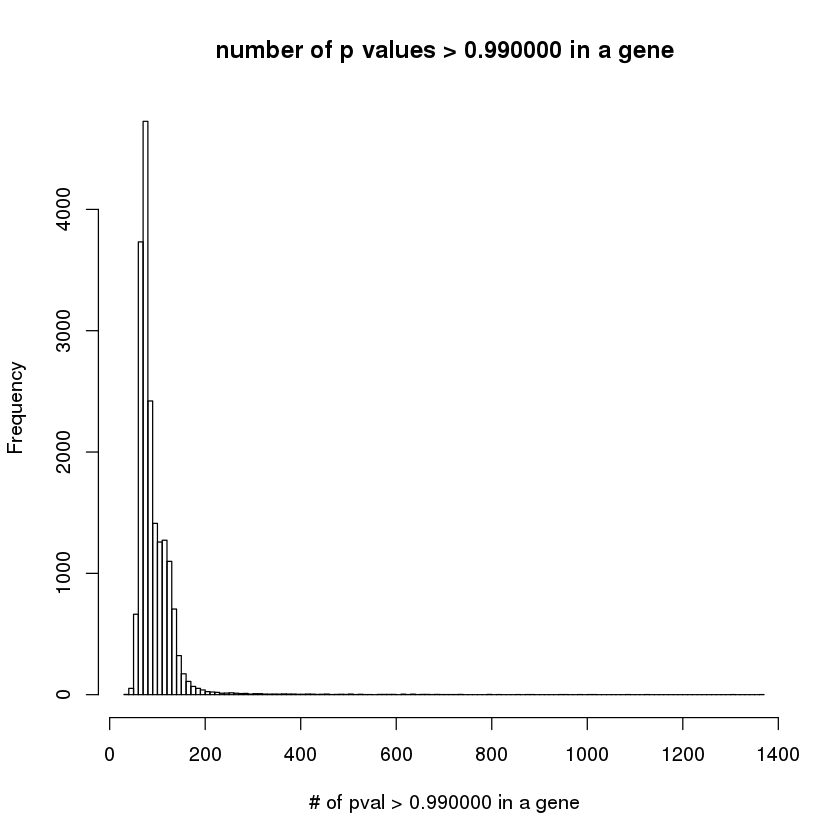

In [17]:
hist(colSums(pval_bin), breaks = 100, xlab = sprintf("# of pval > %f in a gene", threshold), 
     main = sprintf("number of p values > %f in a gene", threshold))

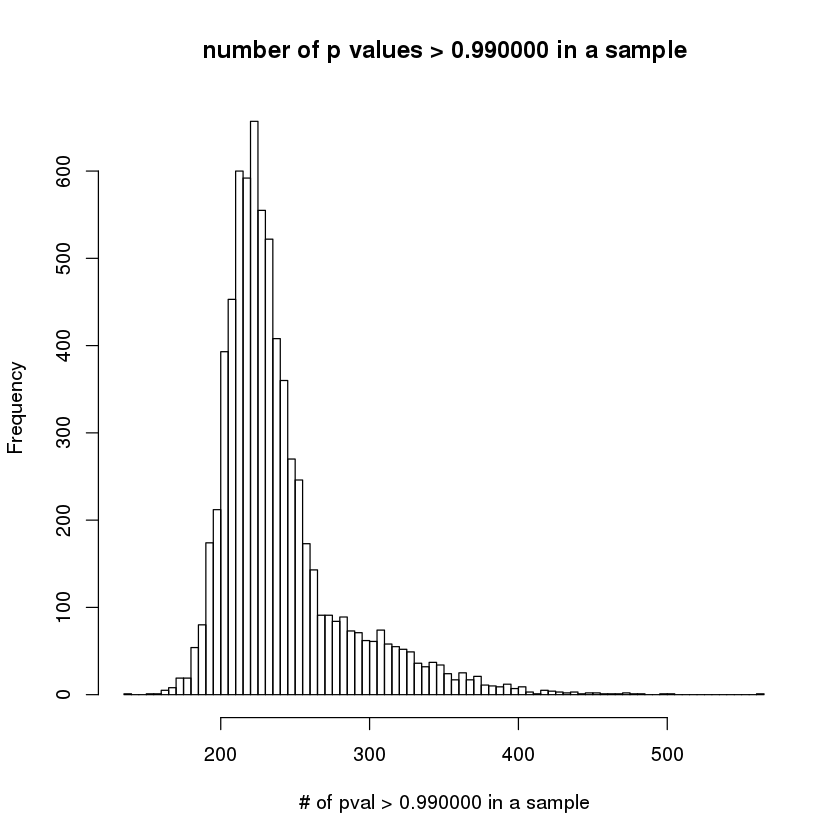

In [18]:
hist(rowSums(pval_bin), breaks = 100, xlab = sprintf("# of pval > %f in a sample", threshold), 
     main = sprintf("number of p values > %f in a sample", threshold))

# Find Eigenvalues of binary matrix

I form a binary matrix of the same size as original data. An ertry is one if the p value is larger than 0.9. Then I compute its eigenvalues. 

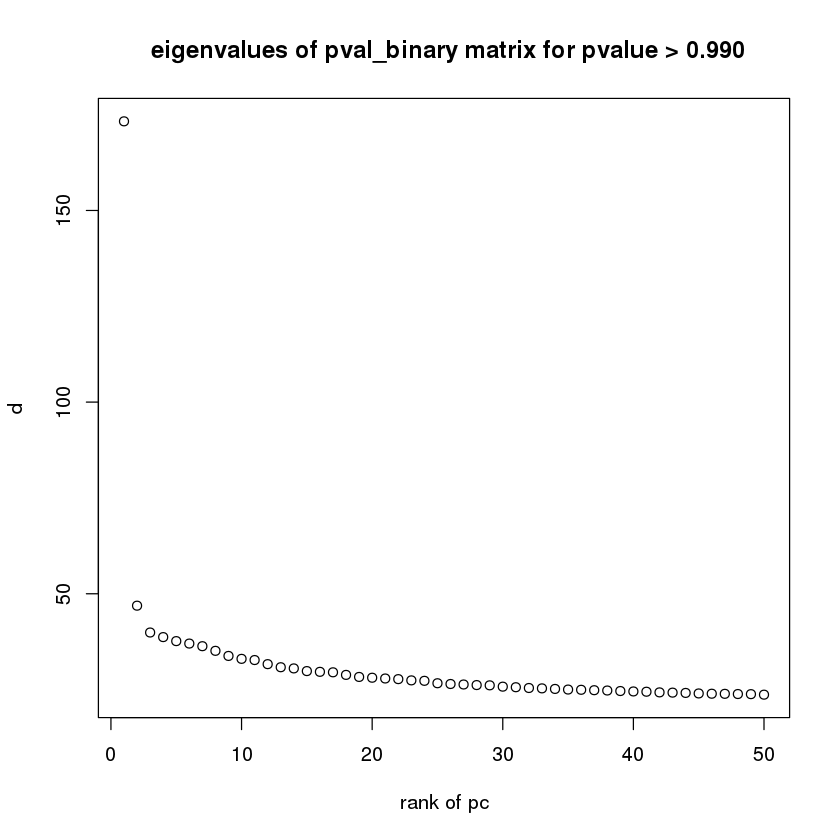

In [19]:
set.seed(12345)
svd_out = rsvd(pval_bin,k = 50)
plot(svd_out$d, xlab = "rank of pc", ylab = "d", 
     main = sprintf(" eigenvalues of pval_binary matrix for pvalue > %.3f", threshold))

In [20]:
print("see the scale of the eigenvalues")
svd_out$d

[1] "see the scale of the eigenvalues"


[1] 173.25478  46.88810  39.88675  38.68967  37.64211  37.00354  36.31774
 [8]  35.10796  33.77626  33.01570  32.70355  31.63326  30.82799  30.52025
[15]  29.82363  29.62773  29.50488  28.83046  28.29593  28.09131  27.89070
[22]  27.72470  27.39808  27.28334  26.65248  26.45513  26.32450  26.17478
[29]  26.10518  25.76116  25.61111  25.41106  25.31389  25.16713  25.00652
[36]  24.94334  24.83640  24.75422  24.61926  24.50930  24.43819  24.26609
[43]  24.20357  24.12607  23.98929  23.91869  23.89007  23.83753  23.80664
[50]  23.67033